# モジュールのインポート

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# データの読み込み

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

# 前処理

In [6]:
# 各カラムの欠損値の確認
print(df_train.isnull().sum())
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:
# Embarkedの欠損値補完
# 最頻値を確認
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
# 最頻値のSで欠損値を補完
df_train['Embarked'] = df_train['Embarked'].fillna('S')

In [9]:
# Sの数が+2されているか確認
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
# SibSp:spouses aboard the Titanic(タイタニックに乗船している配偶者)
# Parch:children aboard the Titanic(タイタニックに乗船している子供) 
# これらの和に+1することで世帯数を表現する
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1

In [11]:
# 世帯数=1を1, それ以外の世帯数(2以上）を0とするカラムAloneを作成
df_train = df_train.assign(
  Alone = (df_train['Family'] == 1).astype(int)
)

In [12]:
df_test = df_test.assign(
    Alone = (df_test['Family'] == 1).astype(int)
)

In [13]:
# Ageの欠損値を中央値で補完
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())

In [14]:
# Fareの欠損値を中央値で補完
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

In [15]:
df_train.pivot_table(index='Pclass', columns='SibSp', values='Survived', aggfunc='mean')

SibSp,0,1,2,3,4,5,8
Pclass,,,,,,,
1,0.562044,0.746479,0.800000,0.666667,NaN,NaN,NaN
2,0.416667,0.581818,0.500000,1.000000,NaN,NaN,NaN
3,0.236467,0.325301,0.333333,0.083333,0.166667,0.0,0.0


In [16]:
df_train.pivot_table(index='Pclass', columns='Parch', values='Survived', aggfunc='mean')

Parch,0,1,2,3,4,5,6
Pclass,,,,,,,
1,0.607362,0.677419,0.761905,NaN,0.0,NaN,NaN
2,0.358209,0.750000,0.812500,1.000000,NaN,NaN,NaN
3,0.225722,0.363636,0.255814,0.333333,0.0,0.2,0.0


In [17]:
# Pclass×Familyのクロス集計でSurvivedの値の平均値を確認
df_train.pivot_table(index='Pclass', columns='Family', values='Survived', aggfunc='mean')

Family,1,2,3,4,5,6,7,8,11
Pclass,,,,,,,,,
1,0.532110,0.728571,0.750000,0.714286,1.0,0.5,NaN,NaN,NaN
2,0.346154,0.529412,0.677419,0.769231,1.0,1.0,NaN,NaN,NaN
3,0.212963,0.350877,0.425532,0.666667,0.0,0.0,0.333333,0.0,0.0


In [18]:
df_train.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean')

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [19]:
# df_train['Name']のみだとSeries型になる
# Series型をlist型にするときにはtolist()関数を使用
df_train['Name'].tolist()[:5]

['Braund, Mr. Owen Harris',
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
 'Heikkinen, Miss. Laina',
 'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
 'Allen, Mr. William Henry']

In [21]:
# NaNはfloatなので
df_train['Has_Cabin'] = df_train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df_test['Has_Cabin'] = df_test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [22]:
# 文字型データをダミー変換
# df_train['Sex'] = pd.get_dummies(df_train['Sex'])
df_train['Embarked'] = pd.get_dummies(df_train['Embarked'])
# df_test['Sex'] = pd.get_dummies(df_test['Sex'])
df_test['Embarked'] = pd.get_dummies(df_test['Embarked'])

In [23]:
# 処理が難しいカラムはいったん削除
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [24]:
# 上記処理で欠損値が消えたかどうか確認
print(df_train.isnull().sum())
print(df_train.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
Alone          0
Has_Cabin      0
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
Alone          0
Has_Cabin      0
dtype: int64


In [25]:
first_female = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'female':
        first_female.append(1)
    else:
        first_female.append(0)
df_train['first_female'] = first_female

In [26]:
second_female = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'female':
        second_female.append(1)
    else:
        second_female.append(0)
df_train['second_female'] = second_female

In [27]:
third_female = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'female':
        third_female.append(1)
    else:
        third_female.append(0)
df_train['third_female'] = third_female

In [28]:
first_male = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'male':
        first_male.append(1)
    else:
        first_male.append(0)
df_train['first_male'] = first_male

In [29]:
second_male = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'male':
        second_male.append(1)
    else:
        second_male.append(0)
df_train['second_male'] = second_male

In [30]:
third_male = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'male':
        third_male.append(1)
    else:
        third_male.append(0)
df_train['third_male'] = third_male

In [31]:
first_female2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'female':
        first_female2.append(1)
    else:
        first_female2.append(0)
df_test['first_female'] = first_female2

In [32]:
second_female2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'female':
        second_female2.append(1)
    else:
        second_female2.append(0)
df_test['second_female'] = second_female2

In [33]:
third_female2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'female':
        third_female2.append(1)
    else:
        third_female2.append(0)
df_test['third_female'] = third_female2

In [34]:
first_male2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'male':
        first_male2.append(1)
    else:
        first_male2.append(0)
df_test['first_male'] = first_male2

In [35]:
second_male2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'male':
        second_male2.append(1)
    else:
        second_male2.append(0)
df_test['second_male'] = second_male2

In [36]:
third_male2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'male':
        third_male2.append(1)
    else:
        third_male2.append(0)
df_test['third_male'] = third_male2

In [37]:
# Pclass×Sexの値を格納する新しいカラムの準備
# male=1, female=-1に変換
df_train['Sex'] = df_train['Sex'].replace('male', 1).replace('female', -1 )
df_test['Sex'] = df_test['Sex'].replace('male', 1).replace('female', -1 )

In [38]:
# Pclass の値にSexの値を加えた新しいカラムPSを作成
# female=-1にすることでdf_train['Pclass'] + df_train['Sex']とすることで階級が高い女性ほど値が小さくなるようにする
df_train['PS'] = df_train['Pclass'] + df_train['Sex']
df_test['PS'] = df_test['Pclass'] + df_test['Sex']

In [39]:
# ダミー変数がマイナスのままだと予測結果に影響する？ので0,1データにする
# replaceする元データが数値データのときはクォーテーション指定する必要なし
df_train['Sex'] = df_train['Sex'].replace(1, 1).replace(-1, 0 )
df_test['Sex'] = df_test['Sex'].replace(1, 1).replace(-1, 0 )

In [40]:
# 15歳以下かどうかを示すカラム「Child」を作成
# カラムの追加にはassign関数
# ダミー変数にするためにastype(int)を付ける
df_train = df_train.assign(Child = (df_train['Age'] < 16).astype(int))
df_test = df_test.assign(Child = (df_test['Age'] < 16).astype(int))

In [41]:
df_train = df_train.assign(
    wealthy_class = (df_train['Fare'] > 50).astype(int)
)

In [42]:
df_test = df_test.assign(
  wealthy_class = (df_test['Fare'] > 50).astype(int)
)

In [43]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,Has_Cabin,first_female,second_female,third_female,first_male,second_male,third_male,PS,Child,wealthy_class
0,892,3,1,34.5,0,0,7.8292,0,1,1,0,0,0,0,0,0,1,4,0,0
1,893,3,0,47.0,1,0,7.0000,0,2,0,0,0,0,1,0,0,0,2,0,0
2,894,2,1,62.0,0,0,9.6875,0,1,1,0,0,0,0,0,1,0,3,0,0
3,895,3,1,27.0,0,0,8.6625,0,1,1,0,0,0,0,0,0,1,4,0,0
4,896,3,0,22.0,1,1,12.2875,0,3,0,0,0,0,1,0,0,0,2,0,0


In [44]:
df_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,...,Has_Cabin,first_female,second_female,third_female,first_male,second_male,third_male,PS,Child,wealthy_class
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.034212,-0.057527,-0.001652,0.012658,-0.001205,-0.040143,...,0.019919,0.030994,-0.003437,-0.078984,0.015067,0.002834,0.029548,0.008638,-0.017941,0.009686
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.257307,0.168240,0.016639,...,0.316912,0.412581,0.337329,0.104873,-0.012274,-0.172920,-0.407925,-0.594185,0.136107,0.286113
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.549500,-0.243292,0.065997,...,-0.725541,-0.537844,-0.112793,0.363266,-0.623790,-0.137179,0.660798,0.712469,0.121920,-0.610218
Sex,0.042939,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.182333,-0.082853,-0.200988,...,-0.140391,-0.465541,-0.413953,-0.595174,0.293828,0.273973,0.589172,0.789548,-0.111141,-0.187381
Age,0.034212,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.096688,0.030248,-0.245619,...,0.240314,0.121857,-0.015433,-0.195318,0.294884,0.032843,-0.150357,-0.152976,-0.566310,0.168324
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.159651,-0.059528,0.890712,...,-0.040460,0.009405,-0.010021,0.148524,-0.076447,-0.060796,-0.017717,-0.029710,0.352437,0.183908
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.216225,-0.011069,0.783111,...,0.036987,0.032336,0.084784,0.227276,-0.050878,-0.073472,-0.155459,-0.162361,0.351481,0.101429
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096688,0.159651,0.216225,1.000000,0.269335,0.217138,...,0.482075,0.511153,-0.062925,-0.142199,0.280868,-0.093192,-0.314262,-0.469265,0.003753,0.716845
Embarked,-0.001205,0.168240,-0.243292,-0.082853,0.030248,-0.059528,-0.011069,0.269335,1.000000,-0.046215,...,0.208528,0.236086,-0.075296,-0.032361,0.158558,-0.091112,-0.131969,-0.209273,0.023201,0.230479
Family,-0.040143,0.016639,0.065997,-0.200988,-0.245619,0.890712,0.783111,0.217138,-0.046215,1.000000,...,-0.009175,0.022583,0.035508,0.215054,-0.077667,-0.078257,-0.089774,-0.101419,0.416472,0.176367


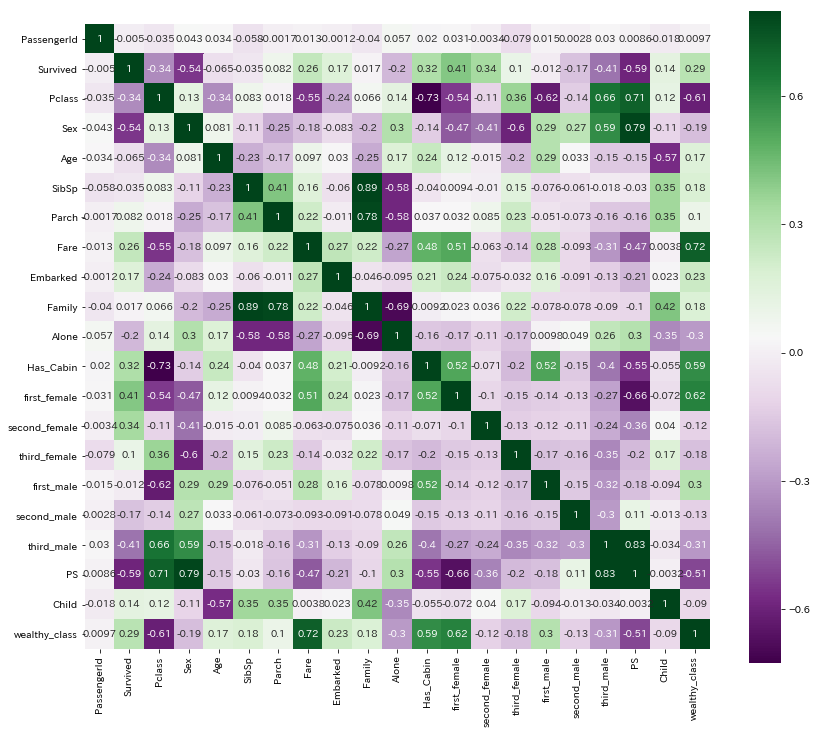

In [45]:
plt.figure(figsize=(14,12))
sns.heatmap(df_train.corr(), vmax=.8, square=True, linecolor='white', cmap = 'PRGn', annot=True )

# モデル作成

In [68]:
# 今回はPassengerId,Survived以外を特徴量にする

In [46]:
train_X = df_train.drop(['PassengerId', 'Survived'], axis = 1)

In [47]:
train_y = df_train['Survived']

In [108]:
model = RandomForestClassifier(n_estimators=50, random_state=0)

In [109]:
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [110]:
train_X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family',
       'Alone', 'Has_Cabin', 'first_female', 'second_female', 'third_female',
       'first_male', 'second_male', 'third_male', 'PS', 'Child',
       'wealthy_class'],
      dtype='object')

In [111]:
# 特徴量毎にランダムフォレストの重要度を確認
for c, m in zip(train_X.columns, model.feature_importances_):
    # print(c, m)
    print('{} : {}'.format(c, m))

Pclass : 0.023210820733411634
Sex : 0.10831179966345936
Age : 0.22345747460267837
SibSp : 0.022077734588847635
Parch : 0.01972966133318764
Fare : 0.20928650560948714
Embarked : 0.022300169326795075
Family : 0.04079455188793712
Alone : 0.00931466102737581
Has_Cabin : 0.02479941683243898
first_female : 0.036601164065631825
second_female : 0.023013855882035035
third_female : 0.014533949883389368
first_male : 0.007227167657736092
second_male : 0.008684968721168577
third_male : 0.03593559677067195
PS : 0.13460467848011176
Child : 0.022661463269617113
wealthy_class : 0.013454359664019554


# 予測

In [112]:
test_X = df_test.drop(['PassengerId'], axis=1)

In [113]:
pred_y = model.predict(test_X)

In [114]:
pred_y[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

# 提出ファイル作成

In [115]:
output = pd.read_csv('test.csv')

In [116]:
output['Survived'] = pred_y

In [117]:
output[['PassengerId','Survived']].to_csv('submission_180923_1.csv', index=False)

In [ ]:
# score = 0.71770 The score drop